<a href="https://colab.research.google.com/github/meierkilian/iapr2020_gkj/blob/master/labs/lab_02_object_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Gabriel Tornare, Kilian Meier, Jérôme Savary

**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

import sys
IN_COLAB = 'google.colab' in sys.modules

print("Running in Google Colab : {}".format(IN_COLAB))

if IN_COLAB :
    data_base_path = '/content'
else :
    data_base_path = os.path.join(os.pardir, 'data')

data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

Running in Google Colab : False


## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

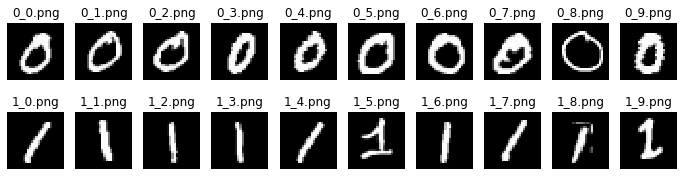

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
#data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors & Active contours
### Implementation
  The three following cells are used globally in the Notebook and implement two contour detection schemes: first using Active Contours and then Using OpenCV native function findContour; as well as the computation of the Fourier coeficient of a given contour. (The OpenCv contour detection scheam will be discussed in the next section.)

### Discussion
  As can be seen in the contour output figures, the contour found by using active contours methode are satisfactory, even if some artifacts are subsiting and it has trouble detecting more complex shapes, like the one_5. It might be possible to fix this by further tunning active contour parameters.
  
  In any case, using the module of coefficient 1 and 2 of the Fourier transform of the contour leads to lineraly classifiable features as can be seen in the feature space scatter plot.

In [7]:
# Import various functions and packages 
# NOTE the dependence with OpenCV !

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from skimage.util import img_as_ubyte
from skimage.morphology import disk
from skimage.morphology import erosion
from skimage.morphology import closing
from skimage.morphology import opening
from skimage.morphology import rectangle
from skimage.morphology import area_closing
from skimage.morphology import area_opening
from skimage.draw import rectangle
from skimage.draw import circle
from skimage.measure import label
from skimage.color import rgb2gray
from skimage import filters
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.filters import sobel
from skimage.filters import median

import warnings 
import cv2 # tested using version 4.1.2
if cv2.__version__ != "4.1.2" :
  warnings.warn("OpenCV currently running version {}, developement version is 4.1.2".format(cv2.__version__))

C:\Users\Gabriel\anaconda3\envs\iapr2020\lib\site-packages\ipykernel_launcher.py:31: UserWarning: OpenCV currently running version 3.4.2, developement version is 4.1.2


In [8]:
def get_contour(im, methode = "AC") :
    """
    This function finds a contour in image im using either Active Contour method
    or the OpenCV native findContours function.

    INPUT :
      im : binary image to search the contour in
      methode : specifies methode to be used to search contour, "AC" for active
                contours, "CV2" for OpenCV's findContours(). Default is "AC"
    OUTPUT :
      im : filtered image used for contour search
      snake : order point list of the contour
    """

    # Filtering 
    im = median(im, disk(2))
    im = area_opening(im, 40)

    # Active Contours
    if methode == "AC" :
        # Create a circle used as a seed for active contours
        s = np.linspace(0, 2*np.pi, 300)
        r = 14 + 10*np.sin(s) 
        c = 14 + 10*np.cos(s)
        init = np.array([r, c]).T  #initial snake

        snake = active_contour(im, init, alpha=4, beta=1, gamma=1,
                           w_line = 0, w_edge = 2, coordinates='rc')
        
    # Contour using OpenCV
    elif methode == "CV2" :
        contours, hierarchy = cv2.findContours(im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        
        c = np.array(contours[0])

        snake = np.array([c[:,0,1],c[:,0,0]]).T
        
    else :
        raise Exception("Unkown methode : {}".format(methode))

    return im, snake
    

In [9]:
def extract_fourier_descriptor(im, methode = "AC"):
    """
    Computes fourier descriptors given a greysclale picture.

    INPUT :
      im : grayscale image to search to contour in
      methode : specifies methode to be used to search contour, see getContour()
                for details
    OUPUT :
      fd : Fourier descriptor coefficients
      snake : order point list of the contour 
      im : filtered image used for contour search
    """
    
    im, snake = get_contour(im, methode)
    
    z = (snake[:,0] + 1j*snake[:,1]) #put the 2D points of the snake in a complex representation
    fd = np.fft.fft(z)

    return fd, snake, im 

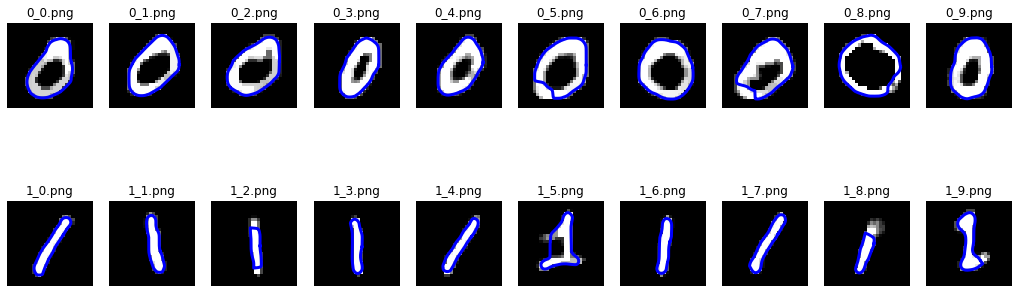

In [10]:
# Initialisation
Zs_AC_01 = [ [] for i in np.arange( len(zeros_im) + len(ones_im) ) ]
snakes = list(zeros_im[0]) #copy only the content, not the reference
im_prepro = list(zeros_im[0]) #copy only the content, not the reference

# Compute Fourier descriptors using Active contours
for idx in np.arange(len(zeros_im)):
    Zs_AC_01[idx], snakes[idx], im_prepro[idx] = extract_fourier_descriptor(zeros_im[idx], "AC")
    Zs_AC_01[idx + len(zeros_im)], snakes[idx+ len(zeros_im)], im_prepro[idx+ len(zeros_im)] = \
        extract_fourier_descriptor(ones_im[idx], "AC")
    

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 6))
for idx, ax, im, nm in zip(np.arange(len(zeros_im)), axes[0], zeros_im, zeros_names):
    ax.plot(snakes[idx][:, 1], snakes[idx][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for idx, ax, im, nm in zip(np.arange(len(ones_im)), axes[1], ones_im, ones_names):
    ax.plot(snakes[idx+ len(zeros_im)][:, 1], snakes[idx+ len(zeros_im)][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx+ len(zeros_im)], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

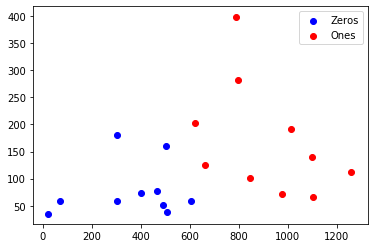

In [11]:
# Extract desired Fourier descriptors
X = [ Zs_AC_01[i][1] for i in np.arange(len(Zs_AC_01)) ]  
Y = [ Zs_AC_01[i][2] for i in np.arange(len(Zs_AC_01)) ]
x = np.absolute(X)
y = np.absolute(Y)

# Plot feature space
plt.scatter(x[0:10], y[0:10], color='blue') #the zeros
plt.scatter(x[10:] , y[10:],  color='red')  #the ones
plt.legend(("Zeros","Ones"))

plt.show()


### 1.3 Fourier descriptor & OpenCV

This section is investigating the impact of a better contour detection on the performance of Fourier descriptors.

### Implementation
See section 1.2. The OpenCV find contour function uses the algorithm described in _Suzuki, S. and Abe, K., Topological Structural Analysis of Digitized Binary Images by Border Following. CVGIP 30 1, pp 32-46 (1985)_. 

### Discussion 
One can see that this implementation leads indeed to better contour as can be seen in the contour output figure.

Using the same feature space as in 1.2, one can see that the cluster spread is much smaller as in 1.2 allowing for easier classification. Moreover the first Fourier coefficient became small for the ones thant for the zeros (the oposit was true in 1.2). However note the two outlier (marked by a crosses in the scatter plot), which are, as might be expected, one_5 and one_9 which are more than a straigth line and thus have a very different contour. Both were'nt outliers in 1.2 since active contours did not capture as well the different contours.

In [12]:
# Initialisation
Zs_CV2_01 = [ [] for i in np.arange( len(zeros_im) + len(ones_im) ) ]
snakes = list(zeros_im[0]) #copy only the content, not the reference
im_prepro = list(zeros_im[0]) #copy only the content, not the reference

# Compute Fourier descriptors using OpenCV's findContours()
for idx in np.arange(len(zeros_im)):
    Zs_CV2_01[idx], snakes[idx], im_prepro[idx] = extract_fourier_descriptor(zeros_im[idx], "CV2")
    Zs_CV2_01[idx + len(zeros_im)], snakes[idx+ len(zeros_im)], im_prepro[idx+ len(zeros_im)] = \
        extract_fourier_descriptor(ones_im[idx], "CV2")
    

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 6))
for idx, ax, im, nm in zip(np.arange(len(zeros_im)), axes[0], zeros_im, zeros_names):
    ax.plot(snakes[idx][:, 1], snakes[idx][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for idx, ax, im, nm in zip(np.arange(len(ones_im)), axes[1], ones_im, ones_names):
    ax.plot(snakes[idx+ len(zeros_im)][:, 1], snakes[idx+ len(zeros_im)][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx+ len(zeros_im)], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

ValueError: too many values to unpack (expected 2)

In [13]:
# Extract desired Fourier descriptors
X = [ Zs_CV2_01[i][1] for i in np.arange(len(Zs_CV2_01)) ]  
Y = [ Zs_CV2_01[i][2] for i in np.arange(len(Zs_CV2_01)) ]
x = np.absolute(X)
y = np.absolute(Y)

# Plot feature space
plt.scatter(x[0:10], y[0:10], color='blue') #the zeros
plt.scatter(x[10:15] , y[10:15],  color='red')  #the ones
plt.scatter(x[16:19] , y[16:19],  color='red')  #the ones
plt.scatter(x[15] , y[15],  color='red', marker="x")  #outlier
plt.scatter(x[19] , y[19],  color='red', marker="x")  #outlier
plt.legend(("Zeros", "Ones"))
plt.show()


IndexError: list index out of range

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

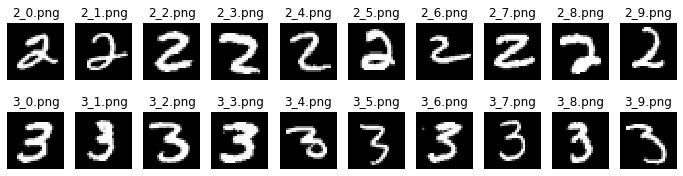

In [14]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors & Active contours

### Implementation 
The same functions are used as in the previous sections on the new data set.

### Discussion
Using the same parameter as in section 1.2 for active active contour detection leads to poor results as can be seen in the contour output plots.

Classifiying tows and threes may be possible despite poor contour detection, however adding in zeros and ones does not allow classification.

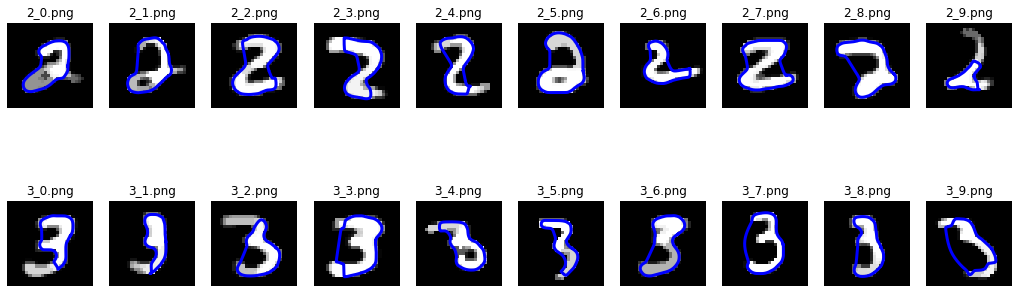

In [15]:
# Initialization
Zs_AC_23 = [ [] for i in np.arange( len(zeros_im) + len(ones_im) ) ]
snakes = list(im) #copy only the content, not the reference
im_prepro = list(im) #copy only the content, not the reference

# Compute Fourier descriptors using Active contours
for idx in np.arange(len(twos_im)):
    Zs_AC_23[idx], snakes[idx], im_prepro[idx] = extract_fourier_descriptor(twos_im[idx], "AC")
    Zs_AC_23[idx + len(zeros_im)], snakes[idx+ len(twos_im)], im_prepro[idx+ len(twos_im)] = extract_fourier_descriptor(threes_im[idx], "AC")
    

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(18, 6))
for idx, ax, im, nm in zip(np.arange(len(twos_im)), axes[0], twos_im, twos_names):
    ax.plot(snakes[idx][:, 1], snakes[idx][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for idx, ax, im, nm in zip(np.arange(len(threes_im)), axes[1], threes_im, threes_names):
    ax.plot(snakes[idx+ len(threes_im)][:, 1], snakes[idx+ len(threes_im)][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx+ len(threes_im)], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

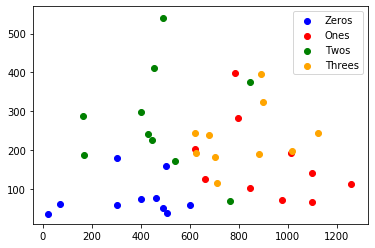

In [16]:
# Extract desired Fourier descriptors
X = np.concatenate(([ Zs_AC_01[i][1] for i in np.arange(len(Zs_AC_01))], 
                    [ Zs_AC_23[i][1] for i in np.arange(len(Zs_AC_23))]))
Y = np.concatenate(([ Zs_AC_01[i][2] for i in np.arange(len(Zs_AC_01))], 
                    [ Zs_AC_23[i][2] for i in np.arange(len(Zs_AC_23))]))
x = np.absolute(X)
y = np.absolute(Y)

# Plot feature space
plt.scatter(x[0:10], y[0:10], color='blue') #the zeros
plt.scatter(x[10:20] , y[10:20],  color='red')  #the ones
plt.scatter(x[20:30] , y[20:30],  color='green')  #the twos
plt.scatter(x[30:40] , y[30:40],  color='orange')  #the threes
plt.legend(("Zeros","Ones","Twos","Threes"))
plt.show()

### 2.3 Fourier descriptors & OpenCV
Again this section aimes at investingating the impact of a better contour detection.

### Implementation 
The same functions are used as in the previous sections on the new data set.

### Discussion
Again the OpenCV function performs better than active contours.

However, as can be seen in the feature space plot, classification between all 4 classes is still not possible. However it might be possible to classify between zeros, ones and threes.

In [17]:
# Initialization
Zs_CV2_23 = [ [] for i in np.arange( len(zeros_im) + len(ones_im) ) ]
snakes = list(im) #copy only the content, not the reference
im_prepro = list(im) #copy only the content, not the reference

# Compute Fourier descriptors using OpenCV's findContours()
for idx in np.arange(len(twos_im)):
    Zs_CV2_23[idx], snakes[idx], im_prepro[idx] = extract_fourier_descriptor(twos_im[idx], "CV2")
    Zs_CV2_23[idx + len(zeros_im)], snakes[idx+ len(twos_im)], im_prepro[idx+ len(twos_im)] = extract_fourier_descriptor(threes_im[idx], "CV2")
    

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(18, 6))
for idx, ax, im, nm in zip(np.arange(len(twos_im)), axes[0], twos_im, twos_names):
    #ax.plot(init[:, 1], init[:, 0], '--r', lw=3)  #initial snake, not needed
    ax.plot(snakes[idx][:, 1], snakes[idx][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for idx, ax, im, nm in zip(np.arange(len(threes_im)), axes[1], threes_im, threes_names):
    ax.plot(snakes[idx+ len(threes_im)][:, 1], snakes[idx+ len(threes_im)][:, 0], '-b', lw=3)
    ax.imshow(im_prepro[idx+ len(threes_im)], cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

ValueError: too many values to unpack (expected 2)

In [18]:
# Extract desired Fourier descriptors
X = np.concatenate(([ Zs_CV2_01[i][1] for i in np.arange(len(Zs_CV2_01))], [ Zs_CV2_23[i][1] for i in np.arange(len(Zs_CV2_23))]))
Y = np.concatenate(([ Zs_CV2_01[i][2] for i in np.arange(len(Zs_CV2_01))], [ Zs_CV2_23[i][2] for i in np.arange(len(Zs_CV2_23))]))
x = np.absolute(X)
y = np.absolute(Y)

# Plot feature space
plt.scatter(x[0:10], y[0:10], color='blue') #the zeros
plt.scatter(x[10:20] , y[10:20],  color='red')  #the ones
plt.scatter(x[20:30] , y[20:30],  color='green')  #the twos
plt.scatter(x[30:40] , y[30:40],  color='orange')  #the threes
plt.legend(("Zeros","Ones","Twos","Threes"))
plt.show()

IndexError: list index out of range